In [1]:
import logging
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset

from src.model import ChemicalMetaRegressor

np.random.seed(42)
ds = load_dataset("openadmet/openadmet-expansionrx-challenge-train-data")
ds_test = load_dataset("openadmet/openadmet-expansionrx-challenge-test-data-blinded")
train_df = ds["train"].to_pandas().sample(100)
test_df = ds_test["test"].to_pandas().sample(100)

/home/jonswain/miniconda3/envs/OpenADMET_challenge/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


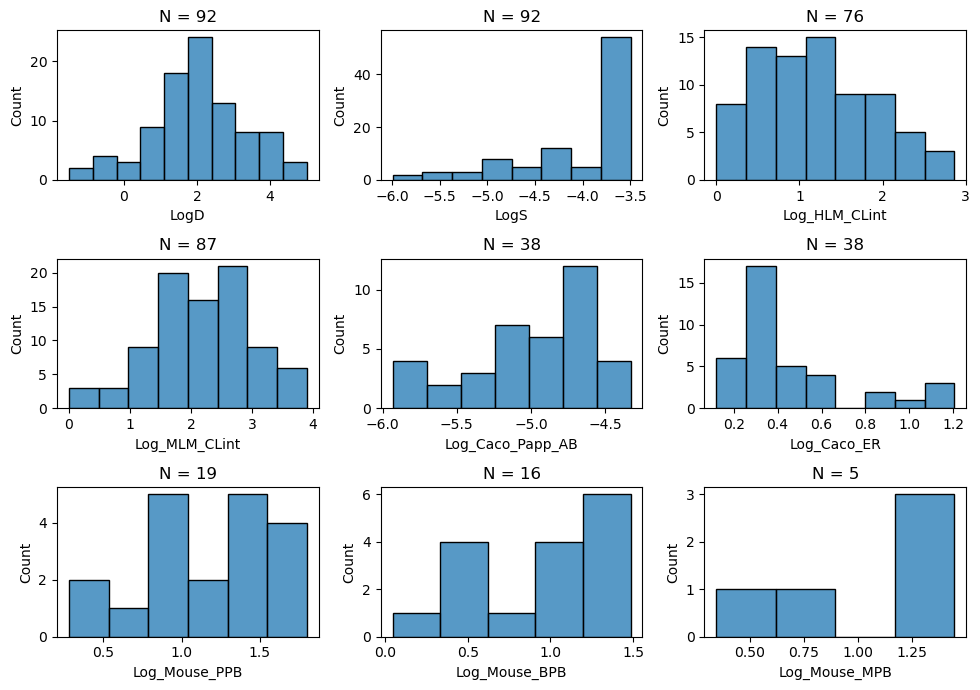

In [2]:
data = """Assay,Log_Scale,Multiplier,Log_name
LogD,False,1,LogD
KSOL,True,1e-6,LogS
HLM CLint,True,1,Log_HLM_CLint
MLM CLint,True,1,Log_MLM_CLint
Caco-2 Permeability Papp A>B,True,1e-6,Log_Caco_Papp_AB
Caco-2 Permeability Efflux,True,1,Log_Caco_ER
MPPB,True,1,Log_Mouse_PPB
MBPB,True,1,Log_Mouse_BPB
MGMB,True,1,Log_Mouse_MPB
"""
s = StringIO(data)
conversion_df = pd.read_csv(s)
conversion_dict = dict([(x[0], x[1:]) for x in conversion_df.values])
log_train_df = train_df[["SMILES", "Molecule Name"]].copy()
for col in train_df.columns[2:]:
    log_scale, multiplier, short_name = conversion_dict[col]
    log_train_df[short_name] = train_df[col].astype(float)
    if log_scale:
        log_train_df[short_name] = log_train_df[short_name] + 1
        log_train_df[short_name] = np.log10(log_train_df[short_name] * multiplier)

figure, axes = plt.subplots(3, 3, figsize=(10, 7))
axes = axes.flatten()
log_col_names = log_train_df.columns[2:]
for i, col in enumerate(log_col_names):
    ax = sns.histplot(log_train_df[col], ax=axes[i])
    ax.set_title(f"N = {len(log_train_df.dropna(subset=col))}")
plt.tight_layout()

In [3]:
logging.basicConfig(
    level=logging.INFO,
    format="[%(asctime)s] %(levelname)s [%(module)s]: %(message)s",
)

reg = ChemicalMetaRegressor(
    smiles_col="SMILES",
    target_cols=log_train_df.columns[2:-1].to_list(),
    training_data=log_train_df,
)
reg.train_models(n_keep_classical=3, tune_hyperparameters=False)

[2025-10-31 12:36:45,161] INFO [model]: Generating features for training data
Calculating distances for clustering: 100%|██████████| 99/99 [00:00<00:00, 5801.01it/s]
[2025-10-31 12:36:46,622] INFO [model]: Training classical models
[2025-10-31 12:36:46,623] INFO [training_classical_models]: Training classical models for target: LogD
[2025-10-31 12:36:46,624] INFO [training_classical_models]: Number of training samples 92
[2025-10-31 12:36:46,877] INFO [training_classical_models]: LinearRegression MAE: 0.63 (in 0.24s)
[2025-10-31 12:36:47,052] INFO [training_classical_models]: Lasso MAE: 1.01 (in 0.17s)
[2025-10-31 12:36:47,251] INFO [training_classical_models]: Ridge MAE: 0.63 (in 0.20s)
[2025-10-31 12:36:47,431] INFO [training_classical_models]: ElasticNet MAE: 0.86 (in 0.18s)
[2025-10-31 12:36:49,377] INFO [training_classical_models]: ExtraTreesRegressor MAE: 0.68 (in 1.95s)
[2025-10-31 12:36:51,805] INFO [training_classical_models]: GradientBoostingRegressor MAE: 0.72 (in 2.43s)
[20

KeyboardInterrupt: 

In [ ]:
prediction_df = reg.predict(test_df["SMILES"], return_model_choices=True)
prediction_df = (
    test_df[["SMILES", "Molecule Name"]]
    .merge(prediction_df, left_on="SMILES", right_index=True)
    .set_index("SMILES")
)
prediction_df

In [ ]:
import warnings

log_train_df["dataset"] = "train"
prediction_df["dataset"] = "test"
combo_cols = ["Molecule Name", "dataset"] + list(log_col_names)[:-1]
combo_df = pd.concat(
    [log_train_df[combo_cols], prediction_df[combo_cols]], ignore_index=True
)
# transform the data to "tall" format
melt_df = combo_df.melt(id_vars=["Molecule Name", "dataset"])
melt_df.columns = ["Molecule Name", "dataset", "Assay", "Log_Value"]
melt_df["Log_Value"] = melt_df["Log_Value"].clip(-10, 10)
# plot the box plot
ax = sns.boxplot(x="Assay", y="Log_Value", hue="dataset", data=melt_df)
labels = [x.get_text() for x in ax.get_xticklabels()]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    ax.set_xticklabels(["\n".join(x.split("_")) for x in labels])

In [ ]:
reverse_dict = dict([(x[-1], x[0:-1]) for x in conversion_df.values])
prediction_df = prediction_df.reset_index()
output_df = prediction_df[["SMILES", "Molecule Name"]].copy()
for col in prediction_df.columns:
    if col not in reverse_dict:
        continue
    orig_name, log_scale, multiplier = reverse_dict[col]
    output_df[orig_name] = prediction_df[col]
    if log_scale:
        output_df[orig_name] = 10 ** output_df[orig_name] * 1 / multiplier - 1

output_df.to_csv("submission.csv", index=False)
output_df

In [ ]:
preds = output_df.copy()
preds["dataset"] = "test"
train_df["dataset"] = "train"
combined = pd.concat([train_df, preds], ignore_index=True)
columns = preds.columns.tolist()[2:]

fig, ax = plt.subplots(1, len(columns), figsize=(20, 6))
for i, col in enumerate(columns):
    sns.boxplot(
        x="dataset",
        y=col,
        data=combined,
        ax=ax[i],
    )
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

In [ ]:
out_of_range_models = {}

out_of_range_values = (
    prediction_df[log_col_names[:-1]] > log_train_df[log_col_names[:-1]].max()
) | (prediction_df[log_col_names[:-1]] < log_train_df[log_col_names[:-1]].min())

for col in out_of_range_values.columns:
    for model_name, count in (
        prediction_df[f"{col}_model"][out_of_range_values[col]]
        .value_counts()
        .to_dict()
        .items()
    ):
        if model_name not in out_of_range_models:
            out_of_range_models[model_name] = 0
        out_of_range_models[model_name] += count

out_of_range_models

In [ ]:
from src.features import generate_features

good_children = test_df[(out_of_range_values.sum(axis=1) == 0).values].copy()
problem_children = test_df[(out_of_range_values.sum(axis=1) > 1).values].copy()

good_features = generate_features(good_children["SMILES"])
problem_features = generate_features(problem_children["SMILES"])
good_features["dataset"] = "good"
problem_features["dataset"] = "problem"
combined_features = pd.concat([good_features, problem_features], ignore_index=True)

In [ ]:
chunk = 10
fig, ax = plt.subplots(1, chunk, figsize=(15, 4))

for start_pos in range(2048, good_features.shape[1], chunk):
    for i, col in enumerate(good_features.columns[start_pos : start_pos + chunk]):
        sns.boxplot(combined_features, ax=ax[i], y=col, hue="dataset")
        ax[i].set_title(f"{col}")
        ax[i].legend_.remove()
    plt.tight_layout()
    plt.show()